# A quick hands-on tutorial in Supervised ML

In this tutorial we are going to use an already clean dataset from the [Nomadlist Cities](https://nomadlist.com/) data to predict the continent where the city is located.

![alt text](https://source.unsplash.com/1JNk998-g70/800x600)

We are going to encode target-label (world regions), scale our features and try out different algorithms including LogisticRegression, Random Forest and XGBoost. 

We also will try to predict the `nomad-score`, a continuous variable. This is a different kind of problem - a regression problem. We will need to use slightly different tooling for model-fitting and for evaluation.

The tutorial will mostly rely on the Sklearn ML library.
You will see that the syntax and logic of Sklearn is also used in other new libraries like XGBoost

In [1]:
# Import standard Libraries
import pandas as pd
import seaborn as sns
import altair as alt


sns.set(rc={'figure.figsize':(10,10)})

## Loading and selecting the data

In [2]:
# Load data
data = pd.read_csv('https://github.com/CALDISS-AAU/sdsphd20/raw/master/datasets/cities_sds_phd.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cost_nomad              780 non-null    float64
 1   cost_coworking          780 non-null    float64
 2   cost_expat              780 non-null    float64
 3   coffee_in_cafe          780 non-null    float64
 4   cost_beer               780 non-null    float64
 5   places_to_work          780 non-null    float64
 6   free_wifi_available     780 non-null    float64
 7   internet_speed          780 non-null    float64
 8   freedom_score           780 non-null    float64
 9   peace_score             780 non-null    float64
 10  safety                  780 non-null    float64
 11  fragile_states_index    780 non-null    float64
 12  press_freedom_index     780 non-null    float64
 13  female_friendly         780 non-null    float64
 14  lgbt_friendly           780 non-null    fl

In [4]:
# Select the (independant) features that we are going to use to train the model
X = data.loc[:,'cost_nomad':'weed']

In [5]:
# Define the dependant variabel / target to predict (world region)
y = data.region

## Transforming, preprocessing and splitting

In [6]:
# Load and instantiate a LabelEncoder that will turn our text labels (regions into indices)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [7]:
# Transform labels into indices by passing y to the encoder
y_enc = encoder.fit_transform(y)

In [9]:
# Load and instantiate a StandardSclaer 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [12]:
# Apply the scaler to our X-features
X_scaled = scaler.fit_transform(X)

In [13]:
# Split the data using the train_test_split module. We keep 20% of the data for testing and use 80% to train the model
# Random state defined with an arbitrary number for reproducibility

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size = 0.2, random_state = 42)

## Training and evaluating various models

In [14]:
# Import modules that we are going to use for all models

# Import K-fold crossvalidation
from sklearn.model_selection import cross_val_score

# Import Classification Report for later evaluatoion of performance
from sklearn.metrics import classification_report

### LogisticRegression (let's call it that for now without going into details)

In [15]:
# Import and instantiate the model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=2000)

# K-fold cross-validation (splitting the 80% into 5 chunks, using 4 to train and 1 to evaluate)
scores = cross_val_score(model, X_train, y_train, cv = 5)
print(scores)

[0.704     0.704     0.672     0.672     0.7016129]


In [16]:
# Model training
model.fit(X_train, y_train)

# Model performance on the test-set
print(model.score(X_test, y_test))

0.6666666666666666


The overall accuracy is at 65% which is not too impressive. In a multiclass setting that number is also somewhat hard to interpret and that's where it's useful to look at other evaluation statistics

In [17]:
# Performance evaluation using the classification_report

target_names = encoder.inverse_transform(list(set(y_test))) # get real region names back using inverse_transform

y_pred = model.predict(X_test) # predict from the testset

print(classification_report(y_test, y_pred, target_names = target_names)) #Print out the report

              precision    recall  f1-score   support

      Africa       0.30      0.38      0.33         8
    Americas       0.66      0.67      0.67        46
        Asia       0.76      0.69      0.72        51
      Europe       0.67      0.71      0.69        48
     Oceania       0.50      0.33      0.40         3

    accuracy                           0.67       156
   macro avg       0.58      0.56      0.56       156
weighted avg       0.67      0.67      0.67       156



Logistic regression is not doing too well. It is particularly bad when predicting African cities.

Here the recall score is perhaps more interesting than the precision score.

#### Let's inspect the performance visually

In [18]:
!pip uninstall -qq mlxtend -y

In [19]:
# For that we need to install an updated version of the MLxtend library (it will make plotting of the confusion matrix easy)
!pip install -qq -U mlxtend

     |████████████████████████████████| 1.3MB 5.9MB/s 


In [20]:
# Import the confusion matrix plotter module
from mlxtend.plotting import plot_confusion_matrix

# We will also import sklearns confusion matrix module that will make it easy to produce a confusion matrix
# It's actually just a cross-tab of predicted vs. real values
from sklearn.metrics import confusion_matrix

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa194097cf8>)

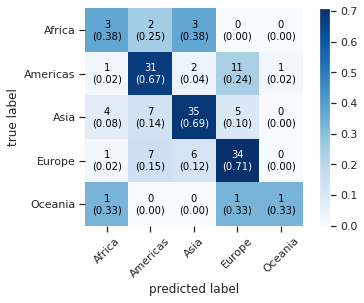

In [21]:
# calculate the confusion matrix
confmatrix = confusion_matrix(y_test,y_pred) 

# Let's plot
plot_confusion_matrix(conf_mat=confmatrix,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                hide_spines = True,
                                class_names=target_names)

As you can see, the model struggeled a lot with African cities and places in Oceania. That is probably also because those are not too many in the data and thus it is hard for the model to learn abot their characteristics.

Some vities form the Americas have been placed in Europe (probably places like Boston or cities in Latinamerica that are similar to Southern Europe). It's an interesting exercise to explore misplaced observations...

### Random Forest
Now we can try out a more complex model (and hopefully more powerfull)
The process is exactly the same and thus there are not too many comments in the code

In [25]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

scores = cross_val_score(model, X_train, y_train, cv = 5)
print(scores)

[0.88       0.904      0.84       0.784      0.87096774]


In [26]:
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.8717948717948718


The test-score is well within the values produced in the crossvalidation
Overall performance goes up (as expected)

In [27]:
# Performance evaluation using the classification_report

target_names = encoder.inverse_transform(list(set(y_test))) # get real region names back using inverse_transform

y_pred = model.predict(X_test) # predict from the testset

print(classification_report(y_test, y_pred, target_names=target_names)) #Print out the report

              precision    recall  f1-score   support

      Africa       0.57      0.50      0.53         8
    Americas       0.95      0.87      0.91        46
        Asia       0.88      0.84      0.86        51
      Europe       0.84      0.98      0.90        48
     Oceania       1.00      0.67      0.80         3

    accuracy                           0.87       156
   macro avg       0.85      0.77      0.80       156
weighted avg       0.87      0.87      0.87       156



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa191e25278>)

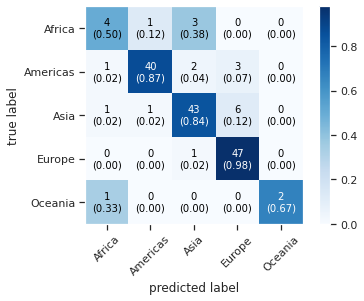

In [28]:
# calculate the confusion matrix
confmatrix = confusion_matrix(y_test,y_pred) 

# Let's plot
plot_confusion_matrix(conf_mat=confmatrix,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names = target_names)

While the model is better at classification of the lartger groups, performance is the same for Oceania and goes down for Africa

### XGBoost
Finally, XGBoost (again we will use standard settings - i.e. no hyperameter tuning)

In [29]:
import xgboost as xgb

model = xgb.XGBClassifier()

scores = cross_val_score(model, X_train, y_train, cv = 5)
print(scores)

model.fit(X_train, y_train)
print(model.score(X_test, y_test))

[0.904      0.896      0.848      0.84       0.87903226]
0.9102564102564102


Overall performance is even higher as with Catboost. But let's see how the algorighm is dealing with our problematic small classes

In [30]:
# Performance evaluation using the classification_report

target_names = encoder.inverse_transform(list(set(y_test))) # get real region names back using inverse_transform

y_pred = model.predict(X_test) # predict from the testset

print(classification_report(y_test, y_pred, target_names=target_names)) #Print out the report

              precision    recall  f1-score   support

      Africa       0.55      0.75      0.63         8
    Americas       0.93      0.91      0.92        46
        Asia       0.98      0.88      0.93        51
      Europe       0.90      0.98      0.94        48
     Oceania       1.00      0.67      0.80         3

    accuracy                           0.91       156
   macro avg       0.87      0.84      0.84       156
weighted avg       0.92      0.91      0.91       156



(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa191e1e940>)

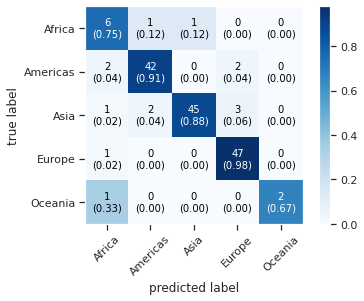

In [31]:
# calculate the confusion matrix
confmatrix = confusion_matrix(y_test,y_pred) 

# Let's plot
plot_confusion_matrix(conf_mat=confmatrix,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names = target_names)

Overall, it seems XGBoost wins this time.

This notebook is only a quick example of the machanics of valious algorithms on small data. 
In real-world situations we would need to spend much more time tuning the models. Also: More compelx models do not always perform better...

## Predicting the Nomad Score

So far we have considered a classificaion problem - the model had to pick one of the 5 options. The outcome variable was a class. Let's shift gears and look at a different type of problem - a prediction where the outcome is a continuous variable. This is our "typical" regression problem.

In the following we are going to predict the nomad score. The inputs into the model will be the same that we already used for predicting the region. We are only going to change the dependant.

In [32]:
# picking a different outcome variable

y_reg = data.nomad_score

In [35]:
# We need to creat new train / test splits here - as the nomad_score was not part of the previous split.

X_train, X_test, y_train, y_test, data_train, data_test = train_test_split(X_scaled, y_reg, data, test_size = 0.2, random_state = 42)

as you can see, I also have the overall dataframe in the split as a 3rd coponent. This is only for some interactive visuals down the line. But yeah, you can do that too... :-) Sometimes it's also handy when passing in some indices that you want to use to get back to data that would be inaccessible.

In [36]:
# Import and instantiate the baseline model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Model training
model.fit(X_train, y_train)

# Model performance on the test-set / This score is not accacy but a R^2
print(model.score(X_test, y_test))

0.8626880465498492


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


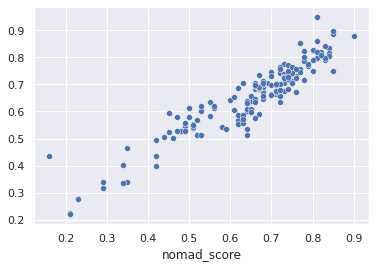

In [39]:
# We can also inspect our results visually
y_pred = model.predict(X_test)

sns.scatterplot(y_test,y_pred)

In [42]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 595 to 168
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cost_nomad              156 non-null    float64
 1   cost_coworking          156 non-null    float64
 2   cost_expat              156 non-null    float64
 3   coffee_in_cafe          156 non-null    float64
 4   cost_beer               156 non-null    float64
 5   places_to_work          156 non-null    float64
 6   free_wifi_available     156 non-null    float64
 7   internet_speed          156 non-null    float64
 8   freedom_score           156 non-null    float64
 9   peace_score             156 non-null    float64
 10  safety                  156 non-null    float64
 11  fragile_states_index    156 non-null    float64
 12  press_freedom_index     156 non-null    float64
 13  female_friendly         156 non-null    float64
 14  lgbt_friendly           156 non-null    

In [43]:
data_test['nomad_score_pred'] = y_pred

alt.Chart(data_test).mark_circle(size=60).encode(
    x='nomad_score',
    y='nomad_score_pred',
    color=alt.Color('region', scale=alt.Scale(scheme='category10')),
    tooltip=['region','weed','place']
).interactive()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


alt.Chart(...)

Let's try a different model class

In [44]:
# Import and instantiate a XGBoost Regressor

model = xgb.XGBRegressor()

# Model training
model.fit(X_train, y_train)

# Model performance on the test-set / This score is not accacy but a R^2
print(model.score(X_test, y_test))

[14:48:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9331527383834222


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


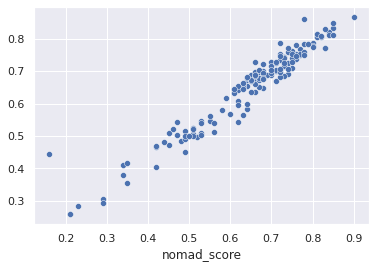

In [45]:
# We can also inspect our results visually
y_pred = model.predict(X_test)

sns.scatterplot(y_test,y_pred)

In [46]:
data_test['nomad_score_pred'] = y_pred

alt.Chart(data_test).mark_circle(size=60).encode(
    x='nomad_score',
    y='nomad_score_pred',
    color=alt.Color('region', scale=alt.Scale(scheme='category10')),
    tooltip=['region','weed','place']
).interactive()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


alt.Chart(...)

# Your turn


In the repo, you will find a dataset describing employee turnover in a company.

https://raw.githubusercontent.com/CALDISS-AAU/sdsphd20/master/datasets/turnover.csv

The dataset contains data collected in an employee survey and enriched with HR data.

The variable `churn` tells us if the employee left the company in the past 3 months. The other variables are collected

## Classification

Try to predict `churn` using a classification pipeline (perhaps add some simple exploration of the data first)

## Regression
Try to predict the number of weekly average hours worked.

**Before** working with the data, you should use `pd.get_dummies` to get dummies for categorical variables.

